In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics 
import csv
import os
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from util.cliffsDelta import cliffsDelta
from util.RQ1_projects import PROJECTS

In [2]:
requests_data = pd.read_csv('./pull_requests_meta_data.csv')
print(list(requests_data))
print(requests_data.shape)

['Unnamed: 0', 'X.', 'project', 'language', 'pull_id', 'pull_number', 'commits_per_pr', 'changed_files', 'churn', 'comments', 'comments_interval', 'merge_workload', 'description_length', 'contributor_experience', 'queue_rank', 'contributor_integration', 'stacktrace_attached', 'activities', 'merge_time', 'delivery_time', 'practice']
(162653, 21)


## original paper - RQ1

In [3]:
time_data = pd.DataFrame()
time_data = requests_data[['project','language','delivery_time','merge_time','practice']]

In [4]:
# comparing the delivery time of merged PRs before and after adopting CI by mean value? 
smean_count, smedian_count, p_count = 0, 0, 0
rq1_delivery_cliffs = []
for name, group in time_data.groupby('project'):
    x = group.loc[group.practice == 'CI']['delivery_time'].values
    y = group.loc[group.practice == 'NO-CI']['delivery_time'].values
    (statistic,pvalue) = mannwhitneyu(x,y)
    
    if pvalue < 0.05:
        p_count += 1
        if x.mean() < y.mean():
            smean_count += 1 
        if np.median(x) < np.median(y):
            smedian_count += 1        
        
        (d, size) = cliffsDelta(x,y)
        d = abs(d)
        rq1_delivery_cliffs.append(d)
        
print('{} out of 87 projects have significant p-values'.format(p_count))
print('{} out of {} projects deliver merged PRs more quickly after adopting CI(compared by mean)'.format(smean_count,p_count))
print('{} out of {} projects deliver merged PRs more quickly after adopting CI(compared by median)'.format(smedian_count,p_count))
# The results are pretty close. 73/87 and 39/87
print('Median of Cliff\'s delta values:' + str(statistics.median(rq1_delivery_cliffs))) 
# This result is quite diff. I get -0.07, original result was 0.304. 

73 out of 87 projects have significant p-values
32 out of 73 projects deliver merged PRs more quickly after adopting CI(compared by mean)
35 out of 73 projects deliver merged PRs more quickly after adopting CI(compared by median)
Median of Cliff's delta values:0.2837202038497371


In [5]:
## Result 2: In 73% (46/63) of the projects, PRs are merged faster before adopting CI.
rq1_merge_neg,rq1_merge_small,rq1_merge_medium,rq1_merge_large = 0,0,0,0
rq1_merge_cliffs = []
smean_count, smedian_count, p_count = 0, 0, 0
for name, group in time_data.groupby('project'):
    x = group.loc[group.practice == 'CI']['merge_time'].values
    y = group.loc[group.practice == 'NO-CI']['merge_time'].values
    (statistic,pvalue) = mannwhitneyu(x,y)
    if pvalue < 0.05:
        p_count += 1
        if x.mean() < y.mean():
            smean_count += 1 
        if np.median(x) < np.median(y):
            smedian_count += 1
        # calculate Cliff's delta for significant projects 
        (d, size) = cliffsDelta(x,y)
        d = abs(d)
        rq1_merge_cliffs.append(d)
        if size == 'negligible':
            rq1_merge_neg += 1
        if size == 'small':
            rq1_merge_small += 1
        if size == 'medium':
            rq1_merge_medium += 1
        if size == 'large':
            rq1_merge_large += 1 
        
print('{} out of 87 projects have significant p-values'.format(p_count))
print('{} out of {} projects merge PRs more quickly after adopting CI(compared by mean)'.format(smean_count,p_count))
print('{} out of {} projects merge PRs more quickly after adopting CI(compared by median)'.format(smedian_count,p_count))

print('In {} projects, {} have negligible Cliff\'s delta value, {} are small, {} are medium and {} are large' 
      .format(p_count,rq1_merge_neg,rq1_merge_small,rq1_merge_medium,rq1_merge_large))
print('Median of Cliff\'s delta values:' + str(statistics.median(rq1_merge_cliffs)) )

# These results are different from the original study's. The R results are same. 

68 out of 87 projects have significant p-values
22 out of 68 projects merge PRs more quickly after adopting CI(compared by mean)
20 out of 68 projects merge PRs more quickly after adopting CI(compared by median)
In 68 projects, 28 have negligible Cliff's delta value, 23 are small, 15 are medium and 2 are large
Median of Cliff's delta values:0.194804519480346


In [7]:
# Result 3: Surprisingly, in 54% of the projects, PRs have a longer lifetime after adopting CI. 
rq1_lifet_cliffs, rq1_lifet_neg,rq1_lifet_small,rq1_lifet_medium,rq1_lifet_large = [],[],[],[],[]
smean_count, smedian_count, p_count = 0, 0, 0
smean_sig_count, smedian_sig_count = 0,0 
for name, group in time_data.groupby('project'):
    ci = group.loc[group.practice == 'CI']
    nci= group.loc[group.practice == 'NO-CI']
    x = ci['merge_time'].values + ci['delivery_time'].values
    y = nci['merge_time'].values + nci['delivery_time'].values
    if x.mean() < y.mean():
        smean_count += 1 
    if np.median(x) < np.median(y):
        smedian_count += 1
    
    (statistic,pvalue) = mannwhitneyu(x,y)
    (d, size) = cliffsDelta(x,y)
    if size == 'negligible':
        rq1_lifet_neg.append(d)
    
    if pvalue < 0.05 and size != 'negligible':
        p_count += 1
        d = abs(d)
        rq1_lifet_cliffs.append(d)
        if size == 'small':
            rq1_lifet_small.append(d)
        if size == 'medium':
            rq1_lifet_medium.append(d)
        if size == 'large':
            rq1_lifet_large.append(d)
            
        if x.mean() < y.mean():
            smean_sig_count += 1 
        if np.median(x) < np.median(y):
            smedian_sig_count += 1

print('{} out of 87 projects have significant p-values and with non-negligible Cliff\'s delta value'.format(p_count))
print('{} out of 87 projects have a longer lifetime after adopting CI(compared by mean)'.format(smean_count))
print('{} out of 87 projects have a longer lifetime after adopting CI(compared by median).'.format(smedian_count))
print('{} have negligible Cliff\'s delta value.\n'.format(p_count,len(rq1_lifet_neg)))

print('{} out of {} projects have a longer lifetime after adopting CI(compared by mean)'.format(smean_sig_count,p_count))
print('{} out of {} projects have a longer lifetime after adopting CI(compared by median).\n'.format(smedian_sig_count,p_count))

print('In {} projects,{} are small with a median value {},\n'
    '                  {} are medium with a median value {},\n '
    '                 and {} are large with a median value {}. \n' 
      .format(p_count, len(rq1_lifet_small), str(round(statistics.median(rq1_lifet_small),3)),
              len(rq1_lifet_medium), str(round(statistics.median(rq1_lifet_medium),3)),
              len(rq1_lifet_large), str(round(statistics.median(rq1_lifet_large),3))
             )
     )
print('Median of Cliff\'s delta values of all significant projects:' + str(round(statistics.median(rq1_lifet_cliffs),3)))

63 out of 87 projects have significant p-values and with non-negligible Cliff's delta value
39 out of 87 projects have a longer lifetime after adopting CI(compared by mean)
38 out of 87 projects have a longer lifetime after adopting CI(compared by median).
63 have negligible Cliff's delta value.

29 out of 63 projects have a longer lifetime after adopting CI(compared by mean)
30 out of 63 projects have a longer lifetime after adopting CI(compared by median).

In 63 projects,28 are small with a median value 0.21,
                  15 are medium with a median value 0.36,
                  and 20 are large with a median value 0.604. 

Median of Cliff's delta values of all significant projects:0.338


## original paper - RQ2

In [9]:
release_data = pd.read_csv('./releases_meta_data.csv')

D:\venv\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


created_pull_requests
Median -- number of PRs per release of CI applied: 42.583333333333336
Median -- number of PRs per release of CI not applied: 15.28888888888889
7.733571961304654e-05 0.332276390540362 medium
merged_pull_requests
Median -- number of PRs per release of CI applied: 27.875
Median -- number of PRs per release of CI not applied: 10.385714285714286
3.948726224681528e-05 0.3466772360945964 medium
----------------------------------------
sum_submitted_pr_churn
Median -- number of PRs per release of CI applied: 11581.82142857143
Median -- number of PRs per release of CI not applied: 5097.0
0.001136456924653437 0.26806711586735366 small


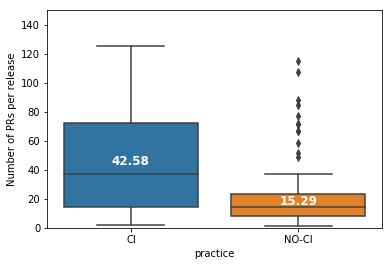

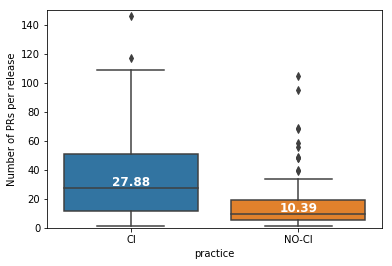

In [10]:
# result 1: 71.3% (62/87) of the projects increase PR submissions after adopting CI. 
def rq2_get_stat(col, conditional=True):
    rq2_col_stat = release_data[['project', col, 'practice']]
    project_summ_ci = {}
    project_summ_nci = {}
    for name, group in rq2_col_stat.groupby('project'):
        # For code churn per release. 
        group = group.fillna(1)
        
        rq2_col_stat_ci = group.loc[group.practice == 'CI'][col].values
        rq2_col_stat_nci= group.loc[group.practice == 'NO-CI'][col].values
        project_summ_ci[name] = np.mean(rq2_col_stat_ci)
        project_summ_nci[name] = np.mean(rq2_col_stat_nci)
        
    if conditional:
        summ_ci = pd.DataFrame.from_dict(project_summ_ci, orient='index', columns=['value'])
        summ_ci['practice'] = 'CI'
        summ_ci = summ_ci.loc[summ_ci.value <= 150]
        summ_nci = pd.DataFrame.from_dict(project_summ_nci, orient='index', columns=['value'])
        summ_nci['practice'] = 'NO-CI'
        summ_nci = summ_nci.loc[summ_nci.value <= 150]
        fig = plt.figure()
        _ax = sns.boxplot(x='practice', y='value', data=pd.concat([summ_ci, summ_nci], ignore_index=True))
        _ax.set(ylim=(0,150), xlabel='practice', ylabel='Number of PRs per release')
        pos = [0,1]
        _values = [round(np.median(list(project_summ_ci.values())),2), round(np.median(np.median(list(project_summ_nci.values()))),2)]
        for tick,label in zip(pos,_ax.get_xticklabels()):
            _ax.text(pos[tick], _values[tick] + 1, _values[tick],horizontalalignment='center', size=12, color='w', weight='heavy')
        
        fig.show()
        fig.savefig(col+".pdf", bbox_inches='tight')
        
    project_summ_ci = list(project_summ_ci.values())
    project_summ_nci = list(project_summ_nci.values())

    print(col)
    # Have the most close results. Values bigger than 150 are not filtered out. 
    print('Median -- number of PRs per release of CI applied: {}'.format(np.median(project_summ_ci)))
    print('Median -- number of PRs per release of CI not applied: {}'.format(np.median(project_summ_nci)))
#         Though seems correct, but deviates from the original results 
#         print('Median -- number of PRs per release of CI applied: {}'.format(summ_ci['value'].describe()['50%']))
#         print('Median -- number of PRs per release of CI not applied: {}'.format(summ_nci['value'].describe()['50%']))
    # Have the most close results 
    (statistic,pvalue) = mannwhitneyu(project_summ_ci, project_summ_nci)
    (d, size) = cliffsDelta(project_summ_ci, project_summ_nci)
#     Though seems correct, but deviates from the original results 
#     (statistic,pvalue) = mannwhitneyu(list(summ_ci['value'].values), list(summ_nci['value'].values))
#     (d, size) = cliffsDelta(list(summ_ci['value'].values), list(summ_nci['value'].values))
    print(pvalue, d, size)
    
rq2_get_stat('created_pull_requests')
rq2_get_stat('merged_pull_requests')
print('-'*40)
rq2_get_stat('sum_submitted_pr_churn',conditional=False)

released_pull_requests
Median -- number of PRs per release of CI applied: 31.72222222222222
Median -- number of PRs per release of CI not applied: 9.25
6.828149076940126e-06 0.3819527018100145 medium


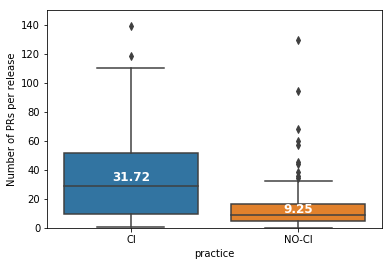

In [11]:
# result 2: After adopting CI projects deliver 3.43 times more PRs per release than before CI. 
rq2_get_stat('released_pull_requests')

D:\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0.3012833463985016


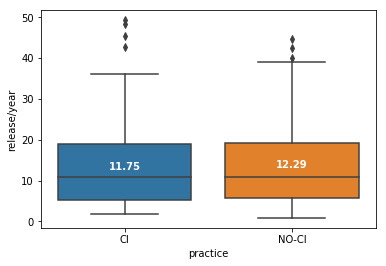

In [12]:
# result 3: We do not observe a significant diﬀerence of release frequency after adopting CI. 
tmp = pd.DataFrame()
tmp = release_data[['startedAt','publishedAt','practice','project']]
tmp['publishedDate'] = pd.to_datetime(tmp['publishedAt']).dt.date
tmp['startedDate'] = pd.to_datetime(tmp['startedAt']).dt.date
rq2_freq_ci = tmp.loc[tmp.practice=='CI']
rq2_freq_nci =  tmp.loc[tmp.practice=='NO-CI']
# project_name: {year:{ci/no-ci:frequency}}
# project_name: mean of release/year 
rq2_deliv_freq_dict = {} 
rq2_deliv_freq_ci, rq2_deliv_freq_nci = {},{}
# rq2_deliv_freq_x,rq2_deliv_freq_y = [],[]

for proj, pgroup in tmp.groupby('project'):
    rq2_freq_ci = pgroup.loc[pgroup.practice=='CI']
    rq2_freq_nci =  pgroup.loc[pgroup.practice=='NO-CI']
    first_ci_date = min(list(rq2_freq_ci['publishedDate'].values))
    created_date = min(list(rq2_freq_nci['publishedDate'].values))
    fetched_date = max(list(rq2_freq_ci['publishedDate'].values))
    
    years_nci = (first_ci_date - created_date).days/365
    years_ci = (fetched_date - first_ci_date).days/365
    rq2_deliv_freq_ci[proj] = rq2_freq_ci.shape[0]/years_ci
    rq2_deliv_freq_nci[proj]= rq2_freq_nci.shape[0]/years_nci

df_rq2_deliv_freq_ci = pd.DataFrame.from_dict(rq2_deliv_freq_ci, columns=['value'], orient='index')
df_rq2_deliv_freq_ci['practice'] = 'CI'
df_rq2_deliv_freq_ci = df_rq2_deliv_freq_ci.loc[df_rq2_deliv_freq_ci.value <= 50]
df_rq2_deliv_freq_nci = pd.DataFrame.from_dict(rq2_deliv_freq_nci, columns=['value'], orient='index')
df_rq2_deliv_freq_nci['practice'] = 'NO-CI'
df_rq2_deliv_freq_nci = df_rq2_deliv_freq_nci.loc[df_rq2_deliv_freq_nci.value <= 50]
ax = sns.boxplot(x='practice',y='value', data=pd.concat([df_rq2_deliv_freq_ci,df_rq2_deliv_freq_nci], ignore_index=True))
ax.set(xlabel='practice', ylabel='release/year')
pos = [0,1]
_values = [round(np.median(list(rq2_deliv_freq_ci.values())),2), round(np.median(list(rq2_deliv_freq_nci.values())), 2)]
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], _values[tick] + 1, _values[tick],horizontalalignment='center', size=10, color='w', weight='semibold')

(statistic,pvalue) = mannwhitneyu(list(rq2_deliv_freq_ci.values()),list(rq2_deliv_freq_nci.values()))
print(pvalue)